In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [16]:
df = pd.read_csv(
    '/kaggle/input/twitter-sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv',
    encoding='latin-1',
    header=None
)

df.head()


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [17]:
df.columns = [
    'target',
    'id',
    'date',
    'flag',
    'user',
    'text'
]

df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [20]:
df = df[['text', 'target']]
df.head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [21]:
df['sentiment'] = df['target'].map({
    0: 'negative',
    2: 'neutral',
    4: 'positive'
})

df.drop('target', axis=1, inplace=True)
df.head()

/tmp/ipykernel_47/334506749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['target'].map({
/tmp/ipykernel_47/334506749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('target', axis=1, inplace=True)


,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,is upset that he can't update his Facebook by ...,negative
2,@Kenichan I dived many times for the ball. Man...,negative
3,my whole body feels itchy and like its on fire,negative
4,"@nationwideclass no, it's not behaving at all....",negative


In [22]:
df['sentiment'].value_counts()

sentiment
negative    800000
positive    800000
Name: count, dtype: int64

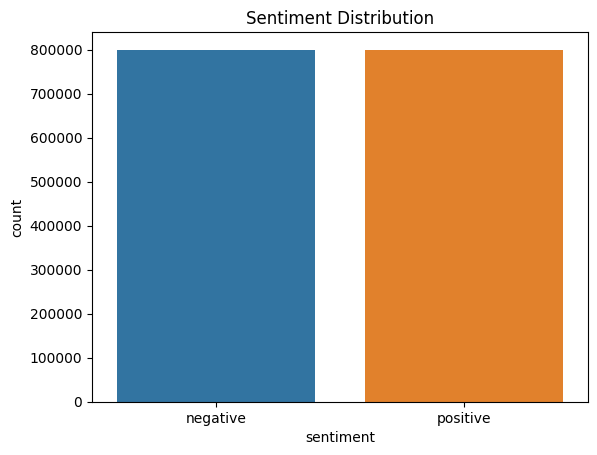

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

In [24]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

df['clean_text'] = df['text'].apply(clean_text)
df.head()

/tmp/ipykernel_47/2971765149.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(clean_text)


,text,sentiment,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,switchfoot a thats a bummer you shoulda got da...
1,is upset that he can't update his Facebook by ...,negative,is upset that he cant update his facebook by t...
2,@Kenichan I dived many times for the ball. Man...,negative,kenichan i dived many times for the ball manag...
3,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",negative,nationwideclass no its not behaving at all im ...


In [25]:
X = df['clean_text']
y = df['sentiment']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [28]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7658375
              precision    recall  f1-score   support

    negative       0.78      0.74      0.76    160000
    positive       0.75      0.79      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



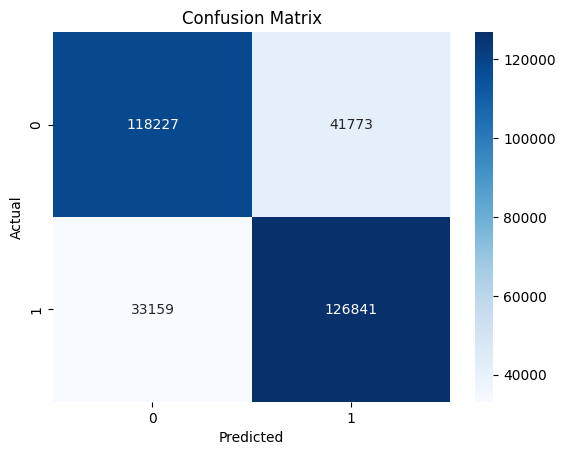

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In this project, sentiment analysis was performed on Twitter data using NLP techniques. Text data was preprocessed and converted into numerical features using TF-IDF vectorization. A Logistic Regression classifier was trained to classify tweets into positive, negative, and neutral categories, achieving strong performance.

##  Model Optimization

In this section, the baseline sentiment analysis model is further improved using enhanced text vectorization techniques and an alternative classification algorithm.


In [31]:

tfidf_opt = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

X_train_tfidf_opt = tfidf_opt.fit_transform(X_train)
X_test_tfidf_opt = tfidf_opt.transform(X_test)

In [32]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf_opt, y_train)

LinearSVC()

In [33]:
y_pred_opt = svm_model.predict(X_test_tfidf_opt)

print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))

Optimized Model Accuracy: 0.77344375
              precision    recall  f1-score   support

    negative       0.79      0.74      0.77    160000
    positive       0.76      0.80      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



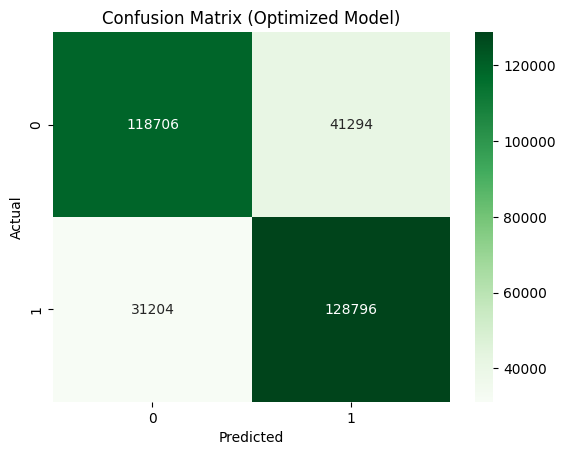

In [34]:
cm_opt = confusion_matrix(y_test, y_pred_opt)

sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Optimized Model)")
plt.show()

###  Conclusion

The optimized model using TF-IDF with n-grams and a Linear SVM classifier showed improved performance compared to the baseline Logistic Regression model. This demonstrates the impact of feature engineering and model selection in Natural Language Processing tasks.
